# Lab 6

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.merge import concatenate
from keras.layers import add
from keras.layers import Activation

import matplotlib.pyplot as plt
import numpy as np

#Source = https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/

# Data Setup

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = np.array(x_train)/255
x_test = np.array(x_test)/255

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

input_shape = (32, 32, 3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


# Architectural Variations

## ResNet
### Skip Connection
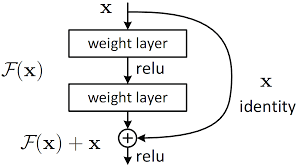

### ResNet vs VGG

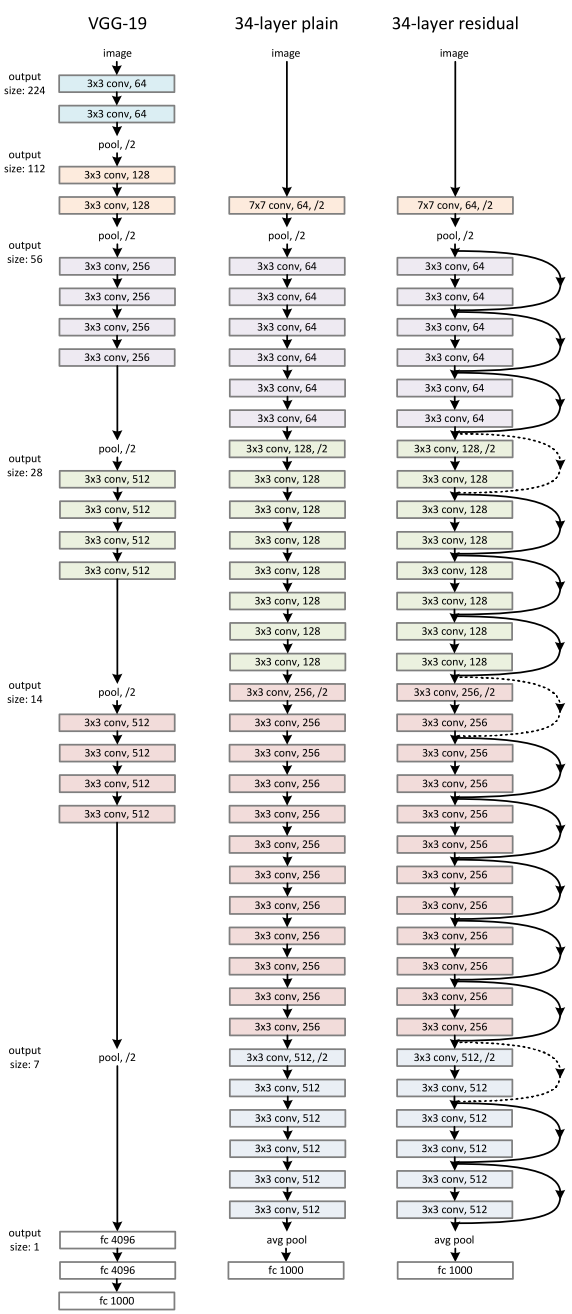

### Residual Module

In [ ]:
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	
	# conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = add([conv2, merge_input])
	# activation function
	layer_out = Activation('relu')(layer_out)
 
	return layer_out

In [ ]:
# Model
inp = Input(shape = input_shape)
res1 = residual_module(inp, 32)
pool1 = MaxPooling2D(pool_size=(2,2), padding='valid')(res1)
res2 = residual_module(pool1, 32)
pool2 = MaxPooling2D(pool_size=(2,2), padding='valid')(res2)
flat = Flatten()(pool2)
dense1 = Dense(64, activation="relu")(flat)
out = Dense(10, activation="softmax")(dense1)

model = Model(inputs = inp, outputs = out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   128         input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size= 512)

Epoch 1/10
98/98 [==============================] - 9s 84ms/step - loss: 1.3083 - accuracy: 0.5330 - val_loss: 1.2450 - val_accuracy: 0.5513
Epoch 2/10
98/98 [==============================] - 7s 74ms/step - loss: 1.1779 - accuracy: 0.5833 - val_loss: 1.1579 - val_accuracy: 0.5866
Epoch 3/10
98/98 [==============================] - 7s 74ms/step - loss: 1.0863 - accuracy: 0.6172 - val_loss: 1.1012 - val_accuracy: 0.6144
Epoch 4/10
98/98 [==============================] - 7s 75ms/step - loss: 1.0078 - accuracy: 0.6447 - val_loss: 1.0016 - val_accuracy: 0.6491
Epoch 5/10
98/98 [==============================] - 7s 75ms/step - loss: 0.9355 - accuracy: 0.6696 - val_loss: 0.9779 - val_accuracy: 0.6608
Epoch 6/10
98/98 [==============================] - 7s 75ms/step - loss: 0.8817 - accuracy: 0.6930 - val_loss: 0.9485 - val_accuracy: 0.6746
Epoch 7/10
98/98 [==============================] - 7s 75ms/step - loss: 0.8499 - accuracy: 0.7029 - val_loss: 0.9272 - val_accuracy: 0.6836
Epoch 8/10
98

## Inception
### Inception Architecture example
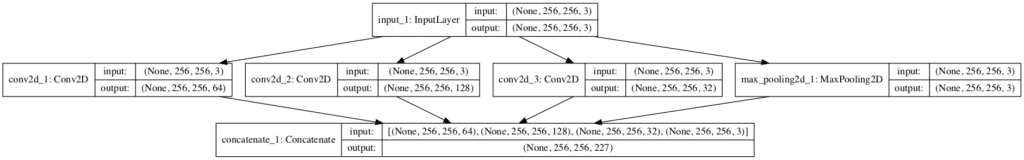

### Inception Module

In [ ]:
def inception_module(layer_in, f1, f2, f3):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
	# 5x5 conv
	conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

In [ ]:
# Model
inp = Input(shape = input_shape)
res1 = inception_module(inp, 16, 32, 32)
pool1 = MaxPooling2D(pool_size=(2,2), padding='valid')(res1)
res2 = inception_module(pool1, 16, 32, 32)
pool2 = MaxPooling2D(pool_size=(2,2), padding='valid')(res2)
flat = Flatten()(pool2)
dense1 = Dense(64, activation="relu")(flat)
out = Dense(10, activation="softmax")(dense1)

model = Model(inputs = inp, outputs = out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 16)   64          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   2432        input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size= 512)

Epoch 1/10
98/98 [==============================] - 12s 110ms/step - loss: 2.0076 - accuracy: 0.2717 - val_loss: 1.6350 - val_accuracy: 0.4143
Epoch 2/10
98/98 [==============================] - 10s 98ms/step - loss: 1.4402 - accuracy: 0.4807 - val_loss: 1.3080 - val_accuracy: 0.5225
Epoch 3/10
98/98 [==============================] - 9s 97ms/step - loss: 1.2367 - accuracy: 0.5620 - val_loss: 1.2101 - val_accuracy: 0.5644
Epoch 4/10
98/98 [==============================] - 9s 97ms/step - loss: 1.1393 - accuracy: 0.5985 - val_loss: 1.1099 - val_accuracy: 0.6075
Epoch 5/10
98/98 [==============================] - 10s 98ms/step - loss: 1.0605 - accuracy: 0.6269 - val_loss: 1.0751 - val_accuracy: 0.6204
Epoch 6/10
98/98 [==============================] - 10s 98ms/step - loss: 1.0004 - accuracy: 0.6490 - val_loss: 1.0149 - val_accuracy: 0.6466
Epoch 7/10
98/98 [==============================] - 10s 98ms/step - loss: 0.9541 - accuracy: 0.6667 - val_loss: 0.9692 - val_accuracy: 0.6596
Epoch 8

# Transfer Learning

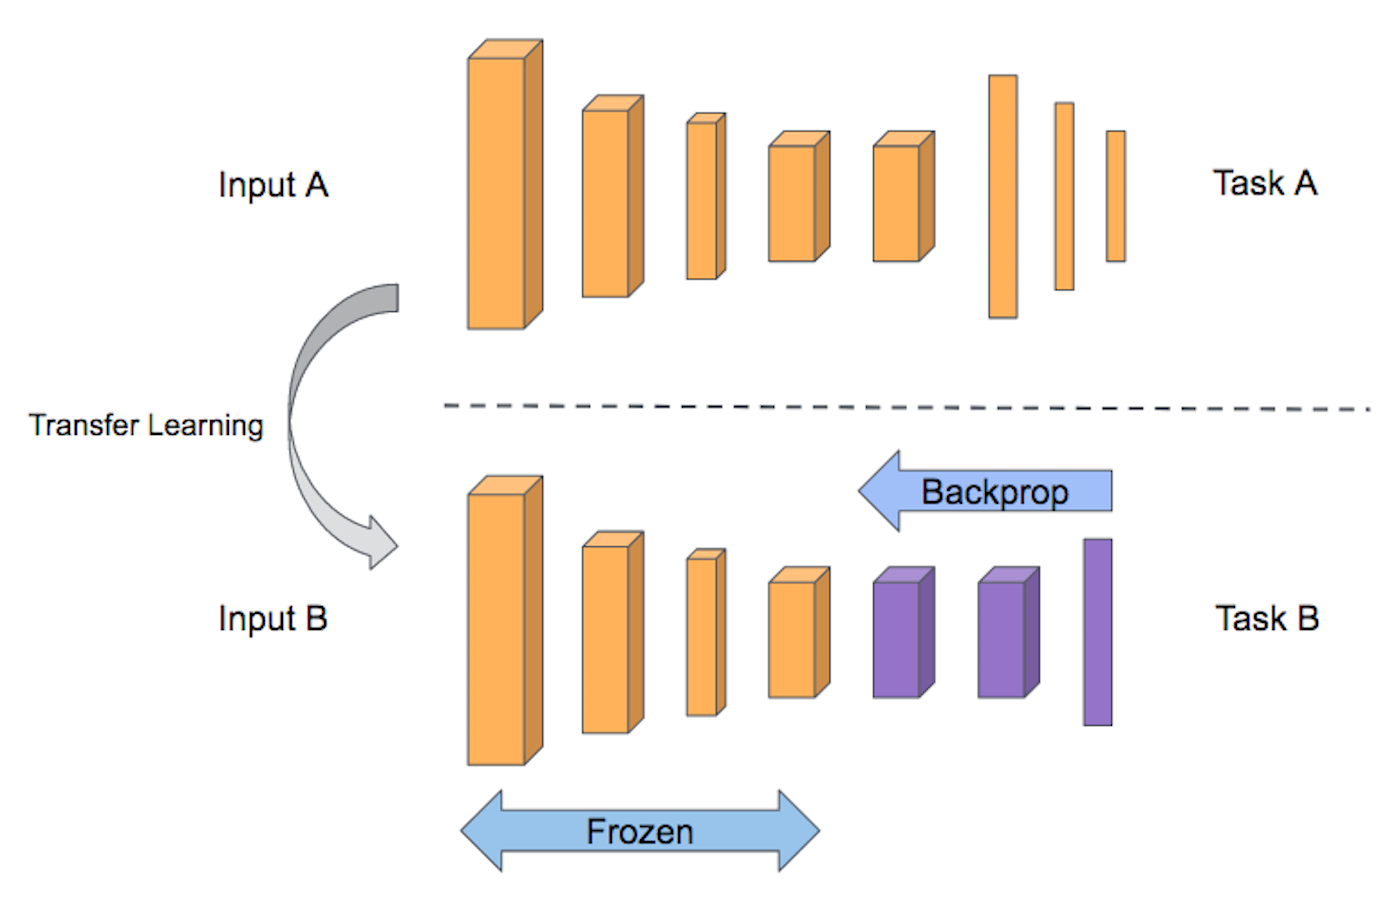

In [ ]:
# example of loading the vgg16 model
from keras.applications.vgg16 import VGG16

model = VGG16()
model.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
model = VGG16(include_top=False, input_shape=(32, 32, 3))

for layer in model.layers:
	layer.trainable = False

flat = Flatten()(model.layers[-1].output)
output = Dense(10, activation='softmax')(flat)

model = Model(inputs=model.inputs, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size= 512)

Epoch 1/10
98/98 [==============================] - 23s 182ms/step - loss: 1.9719 - accuracy: 0.3184 - val_loss: 1.7196 - val_accuracy: 0.4273
Epoch 2/10
98/98 [==============================] - 12s 124ms/step - loss: 1.6162 - accuracy: 0.4616 - val_loss: 1.5540 - val_accuracy: 0.4741
Epoch 3/10
98/98 [==============================] - 12s 124ms/step - loss: 1.4967 - accuracy: 0.4986 - val_loss: 1.4749 - val_accuracy: 0.4993
Epoch 4/10
98/98 [==============================] - 12s 124ms/step - loss: 1.4299 - accuracy: 0.5190 - val_loss: 1.4238 - val_accuracy: 0.5154
Epoch 5/10
98/98 [==============================] - 12s 124ms/step - loss: 1.3850 - accuracy: 0.5326 - val_loss: 1.3887 - val_accuracy: 0.5246
Epoch 6/10
98/98 [==============================] - 12s 124ms/step - loss: 1.3521 - accuracy: 0.5427 - val_loss: 1.3629 - val_accuracy: 0.5318
Epoch 7/10
98/98 [==============================] - 12s 124ms/step - loss: 1.3258 - accuracy: 0.5510 - val_loss: 1.3410 - val_accuracy: 0.5393

In [ ]:
for layer in model.layers:
	layer.trainable = True
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size= 512)

Epoch 1/5
98/98 [==============================] - 12s 127ms/step - loss: 1.2601 - accuracy: 0.5711 - val_loss: 1.2884 - val_accuracy: 0.5538
Epoch 2/5
98/98 [==============================] - 12s 123ms/step - loss: 1.2483 - accuracy: 0.5742 - val_loss: 1.2793 - val_accuracy: 0.5592
Epoch 3/5
98/98 [==============================] - 12s 124ms/step - loss: 1.2386 - accuracy: 0.5790 - val_loss: 1.2712 - val_accuracy: 0.5622
Epoch 4/5
98/98 [==============================] - 12s 124ms/step - loss: 1.2296 - accuracy: 0.5807 - val_loss: 1.2642 - val_accuracy: 0.5637
Epoch 5/5
98/98 [==============================] - 12s 124ms/step - loss: 1.2223 - accuracy: 0.5832 - val_loss: 1.2596 - val_accuracy: 0.5693


# Homework

Create your own variation of of ResNet and compare performance with Pre-trained ResNet from keras.

In [1]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.merge import concatenate
from keras.layers import add
from keras.layers import Activation

import matplotlib.pyplot as plt
import numpy as np

#Source = https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/

## Data Setup

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = np.array(x_train)/255
x_test = np.array(x_test)/255

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

input_shape = (32, 32, 3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

170508288/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


## Residual Module
Expriment with the module architecture

In [15]:
def residual_module(layer_in, n_filters):

	merge_input = layer_in
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	layer_out = add([conv2, merge_input])
	layer_out = Activation('relu')(layer_out)
 
	return layer_out

## New Model

In [16]:
## MAKE YOUR OWN RESNET MODEL AND TRAIN

# Model
inp = Input(shape = input_shape)
res1 = residual_module(inp, 32)
pool1 = MaxPooling2D(pool_size=(2,2), padding='valid')(res1)

res2 = residual_module(pool1, 64)
pool2 = MaxPooling2D(pool_size=(2,2), padding='valid')(res2)

res3 = residual_module(pool2, 96)
pool3 = MaxPooling2D(pool_size=(2,2), padding='valid')(res3)

flat = Flatten()(pool2)
dense1 = Dense(96, activation="relu")(flat)
out = Dense(10, activation="softmax")(dense1)

model = Model(inputs = inp, outputs = out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 32, 32, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 32)   128         input_4[0][0]                    
____________________________________________________________________________________________

In [17]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size= 256)

Epoch 1/15
196/196 [==============================] - 12s 53ms/step - loss: 1.7111 - accuracy: 0.3971 - val_loss: 1.3295 - val_accuracy: 0.5254
Epoch 2/15
196/196 [==============================] - 10s 50ms/step - loss: 1.1896 - accuracy: 0.5798 - val_loss: 1.0806 - val_accuracy: 0.6200
Epoch 3/15
196/196 [==============================] - 10s 51ms/step - loss: 0.9963 - accuracy: 0.6537 - val_loss: 0.9774 - val_accuracy: 0.6589
Epoch 4/15
196/196 [==============================] - 10s 51ms/step - loss: 0.8826 - accuracy: 0.6939 - val_loss: 0.9128 - val_accuracy: 0.6792
Epoch 5/15
196/196 [==============================] - 10s 51ms/step - loss: 0.7869 - accuracy: 0.7278 - val_loss: 0.8942 - val_accuracy: 0.6919
Epoch 6/15
196/196 [==============================] - 10s 51ms/step - loss: 0.7216 - accuracy: 0.7499 - val_loss: 0.8711 - val_accuracy: 0.6988
Epoch 7/15
196/196 [==============================] - 10s 51ms/step - loss: 0.6513 - accuracy: 0.7732 - val_loss: 0.8393 - val_accuracy:

## Pre-trained Model

In [18]:
## USE PRETAINED NETWORKS AND TRAIN AGAIN
from keras.applications.resnet  import ResNet50

model = ResNet50()
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
print(model.layers)

for layer in model.layers:    # train the new layers of the model without updating the weights of the ResNet50 layers.
	layer.trainable = False

flat = Flatten()(model.layers[-1].output)
x = Dense(128, activation='relu')(flat)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=model.inputs, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

94781440/94765736 [==============================] - 2s 0us/step
[<keras.engine.input_layer.InputLayer object at 0x7ff731f8ba90>, <keras.layers.convolutional.ZeroPadding2D object at 0x7ff7a5bf4e10>, <keras.layers.convolutional.Conv2D object at 0x7ff7a5bf4f90>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff7a5bf1250>, <keras.layers.core.Activation object at 0x7ff7a5bf9fd0>, <keras.layers.convolutional.ZeroPadding2D object at 0x7ff7a5bd7210>, <keras.layers.pooling.MaxPooling2D object at 0x7ff731f90650>, <keras.layers.convolutional.Conv2D object at 0x7ff7a5c24ad0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff7a5e71cd0>, <keras.layers.core.Activation object at 0x7ff7a5c70490>, <keras.layers.convolutional.Conv2D object at 0x7ff7a5c7c190>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff7a5df4050>, <keras.layers.core.Activation object at 0x7ff7a5c2cd90>, <keras.layers.convolutional.Con

In [20]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=12, batch_size= 256)

Epoch 1/12
196/196 [==============================] - 22s 87ms/step - loss: 2.2063 - accuracy: 0.2037 - val_loss: 2.0973 - val_accuracy: 0.2257
Epoch 2/12
196/196 [==============================] - 15s 76ms/step - loss: 1.9865 - accuracy: 0.2863 - val_loss: 1.9334 - val_accuracy: 0.3011
Epoch 3/12
196/196 [==============================] - 15s 77ms/step - loss: 1.9070 - accuracy: 0.3140 - val_loss: 1.8782 - val_accuracy: 0.3277
Epoch 4/12
196/196 [==============================] - 15s 77ms/step - loss: 1.8644 - accuracy: 0.3284 - val_loss: 1.8398 - val_accuracy: 0.3338
Epoch 5/12
196/196 [==============================] - 15s 77ms/step - loss: 1.8255 - accuracy: 0.3447 - val_loss: 1.7940 - val_accuracy: 0.3606
Epoch 6/12
196/196 [==============================] - 15s 77ms/step - loss: 1.7940 - accuracy: 0.3578 - val_loss: 1.8128 - val_accuracy: 0.3470
Epoch 7/12
196/196 [==============================] - 15s 77ms/step - loss: 1.7722 - accuracy: 0.3668 - val_loss: 1.7589 - val_accuracy: